# Read in StatsBomb Open Data 

In [21]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from functions.pitch_plot import drawpitch

%matplotlib inline 
plt.rcParams["font.family"] = "Arial"

### Competitions

In [22]:
# read in info on available data

competitions_info_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json"

competitions_df = pd.DataFrame(requests.get(url=competitions_info_url).json())

competitions_df[competitions_df["competition_name"] == "Premier League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
58,2,27,England,Premier League,male,False,False,2015/2016,2023-07-12T13:59:45.191483,2021-06-13T16:17:31.694,None,2023-07-12T13:59:45.191483
59,2,44,England,Premier League,male,False,False,2003/2004,2023-03-11T10:52:12.579230,2021-06-13T16:17:31.694,None,2023-03-11T10:52:12.579230


In [23]:
# select desired competition and season; get ids

selected_competition = "Premier League"

selected_season = "2015/2016"

competition_season_df = competitions_df[(competitions_df["competition_name"] == selected_competition)
                      & (competitions_df["season_name"] == selected_season)]

competition_id, season_id = competition_season_df.iloc[0][['competition_id','season_id']]

### Matches

In [24]:
matches_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json"

matches_df = pd.DataFrame(requests.get(url=matches_url).json())

for i in list(matches_df):
    
    if type(matches_df[i].tolist()[0]) == dict:
        
        new_cols = pd.json_normalize(matches_df[i])
        
        new_col_names = list(matches_df[i].tolist()[0].keys())

        matches_df = pd.concat(
                [
                    matches_df,
                    pd.DataFrame(
                        new_cols, 
                        index=matches_df.index, 
                        columns=new_col_names
                    )
                ], axis=1
            )
        
        del matches_df[i]
        
    else:
        
        pass

In [25]:
matches_df

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,shot_fidelity_version,xy_fidelity_version,id,name,id,name,country,id,name,country
0,3754058,2016-01-02,16:00:00.000,0,0,available,processing,2021-10-29T23:44:19.940296,2021-06-12T16:17:31.694,20,...,2,2,1,Regular Season,20,King Power Stadium,NaN,5,Andre Marriner,NaN
1,3754245,2015-10-17,16:00:00.000,1,0,available,scheduled,2022-12-01T13:09:17.044015,2021-06-13T16:17:31.694,9,...,2,2,1,Regular Season,33,The Hawthorns,NaN,4,Martin Atkinson,NaN
2,3754136,2015-12-19,18:30:00.000,1,1,available,scheduled,2020-11-12T23:48:19.757269,2021-06-13T16:17:31.694,17,...,2,2,1,Regular Season,4674,St. James'' Park,NaN,4,Martin Atkinson,NaN
3,3754037,2016-04-30,16:00:00.000,2,1,available,processing,2021-07-07T17:59:57.456,2021-06-12T16:17:31.694,36,...,2,2,1,Regular Season,12,Goodison Park,NaN,7,Neil Swarbrick,NaN
4,3754039,2016-02-13,16:00:00.000,1,2,available,processing,2021-07-25T18:09:51.386,2021-06-12T16:17:31.694,26,...,2,2,1,Regular Season,37,Selhurst Park,NaN,9,Robert Madley,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,3754020,2015-08-17,21:00:00.000,1,0,available,scheduled,2022-07-08T21:26:42.829047,2021-06-13T16:17:31.694,2,...,2,2,1,Regular Season,6,Anfield,NaN,2,Craig Pawson,NaN
376,3754267,2015-08-15,16:00:00.000,0,0,available,scheduled,2020-07-29T05:00,2021-06-13T16:17:31.694,2,...,2,2,1,Regular Season,4589,Vicarage Road,NaN,17,Paul Tierney,NaN
377,3754141,2015-08-09,14:30:00.000,0,2,available,scheduled,2020-08-24T23:30:31.273938,2021-06-13T16:17:31.694,1,...,2,2,1,Regular Season,3,Emirates Stadium,NaN,4,Martin Atkinson,NaN
378,3754128,2015-08-08,16:00:00.000,0,1,available,scheduled,2022-07-08T20:29:32.062770,2021-06-13T16:17:31.694,1,...,2,2,1,Regular Season,71,Vitality Stadium,NaN,728,Mark Clattenburg,NaN


In [26]:
# select match to look at; get meta data

home_team, away_team = "Manchester City", "Leicester City"

selected_match = matches_df[(matches_df["home_team_name"] == home_team) &
           (matches_df["away_team_name"] == away_team)]

match_id = selected_match.match_id.iloc[0]

In [27]:
# get match meta data

date, hg, ag = selected_match['match_date'].iloc[0],\
               selected_match['home_score'].iloc[0],\
               selected_match['away_score'].iloc[0]

### Events

In [28]:
# get event data

match_events_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"

match_events_df = pd.DataFrame(requests.get(url=match_events_url.format(match_id)).json())

In [29]:
dict_cols, normal_cols = [], []
for i in list(match_events_df):
    if dict in set([type(i) for i in match_events_df[i]]):
        dict_cols.append(i)
    else:
        normal_cols.append(i)

In [30]:
df = match_events_df

normalized_dfs = [df[c] for c in normal_cols]

for col in dict_cols:
    
    x = pd.json_normalize(df[col])
    
    x.columns = [f"{col}_{i}" for i in list(x)]
    
    normalized_dfs.append(x)
    
final = pd.concat(normalized_dfs, axis=1)

In [31]:
list(final)

['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'duration',
 'related_events',
 'location',
 'under_pressure',
 'counterpress',
 'off_camera',
 'out',
 'type_id',
 'type_name',
 'possession_team_id',
 'possession_team_name',
 'play_pattern_id',
 'play_pattern_name',
 'team_id',
 'team_name',
 'tactics_formation',
 'tactics_lineup',
 'player_id',
 'player_name',
 'position_id',
 'position_name',
 'pass_length',
 'pass_angle',
 'pass_end_location',
 'pass_recipient.id',
 'pass_recipient.name',
 'pass_height.id',
 'pass_height.name',
 'pass_body_part.id',
 'pass_body_part.name',
 'pass_type.id',
 'pass_type.name',
 'pass_outcome.id',
 'pass_outcome.name',
 'pass_switch',
 'pass_cross',
 'pass_assisted_shot_id',
 'pass_goal_assist',
 'pass_through_ball',
 'pass_technique.id',
 'pass_technique.name',
 'pass_aerial_won',
 'pass_shot_assist',
 'pass_cut_back',
 'pass_inswinging',
 'pass_outswinging',
 'pass_no_touch',
 'carry_end_location',
 'ball_receipt_outco

In [32]:
final.type_name.unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Clearance', 'Interception', 'Ball Recovery',
       'Goal Keeper', 'Foul Committed', 'Foul Won', 'Shot', 'Block',
       'Dribbled Past', 'Dribble', 'Miscontrol', 'Dispossessed', 'Duel',
       '50/50', 'Injury Stoppage', 'Referee Ball-Drop', 'Half End',
       'Substitution', 'Tactical Shift', 'Error'], dtype=object)

In [33]:
shots = final[final["type_name"] == "Shot"]
shots

shots[['x','y']] = pd.DataFrame(shots.location.tolist(), index= shots.index)

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\4102570299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots[['x','y']] = pd.DataFrame(shots.location.tolist(), index= shots.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\4102570299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots[['x','y']] = pd.DataFrame(shots.location.tolist(), index= shots.index)


In [34]:
team_name = "Leicester City"

In [35]:
player_shots = shots[shots["possession_team_name"] == team_name]
player_shots

,id,index,period,timestamp,minute,second,possession,duration,related_events,location,...,ball_recovery_recovery_failure,50_50_outcome.id,50_50_outcome.name,substitution_outcome.id,substitution_outcome.name,substitution_replacement.id,substitution_replacement.name,miscontrol_aerial_won,x,y
89,a314654d-4891-4967-aec7-94e00b776908,90,1,00:02:25.895,2,25,5,0.143722,"[14432591-5dbd-4eb6-85c6-746298d41a08, 1da8cab...","[113.1, 39.6]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.1,39.6
318,2a012837-9548-4e94-aaf1-c59a1f66a586,319,1,00:07:36.289,7,36,14,0.089289,[a49a8c3d-e7fc-44ff-ab20-aee5902ed8d9],"[110.5, 34.7]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.5,34.7
465,00320430-a911-492a-994d-7b98f11d050e,466,1,00:10:10.783,10,10,18,0.213919,[17c83f35-f308-4a78-b256-042bf48c432c],"[116.8, 28.4]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.8,28.4
469,1d10d368-181a-46cc-8abe-76778ef7def8,470,1,00:10:53.595,10,53,19,0.285732,[49a7506c-0162-4a78-8b1b-237510747d7b],"[107.3, 39.6]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.3,39.6
910,c1b7d831-18fc-405a-b57e-9cb7682ff4ca,911,1,00:21:43.420,21,43,38,0.886873,"[0868995a-f943-47c2-b690-1a990a2b9924, 42ada87...","[114.4, 35.6]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.4,35.6
1398,5eb212c4-e487-42e2-a8e7-c4746a272d3f,1399,1,00:35:11.998,35,11,64,1.025697,[d21544b1-08b1-486f-ac39-e1abe0b84625],"[97.5, 21.1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.5,21.1
1937,57e8d099-2f03-445d-8d74-b0a635d935d3,1938,2,00:02:41.229,47,41,99,0.773294,[7e4e2828-b209-4ec7-a370-4c80eaba84b3],"[104.3, 32.7]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.3,32.7
2276,b5f29603-d4e5-4249-b89e-d033ff256c03,2277,2,00:14:16.820,59,16,119,1.215464,"[3459279b-80cb-4dbd-a34c-de5a73e66577, ebed6a3...","[111.3, 44.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.3,44.3
2446,99fb3c21-7799-4152-afcc-a79930a67ccd,2447,2,00:21:55.730,66,55,136,0.188892,[9907914d-1478-4217-b1f8-3daef9961e27],"[111.2, 47.3]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.2,47.3
2663,40e6c397-37ad-4ade-a4c0-37e2a63b5311,2664,2,00:27:55.102,72,55,147,0.251524,[ff422392-7ccc-4869-95bf-baa73a1b3177],"[113.6, 29.9]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.6,29.9


In [36]:
xg_sum = player_shots['shot_statsbomb_xg'].sum()

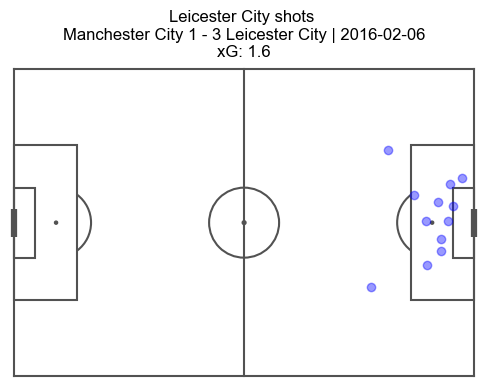

In [37]:
fig,ax = plt.subplots(figsize=(6,4)) 
plt.axis('off')
fig.patch.set_facecolor('white')

drawpitch(ax, hspan = [0, 120], vspan = [80,0],
            linecolor = '#232323', facecolor = '#e8e8e8', arcs = True, \
            lw = 1.5, x_offset = [1,1], y_offset = [-1,-1], style_id = 8,
            grass_cutting = False, measure='SBdata') 

plt.scatter(player_shots['x'],
            player_shots['y'],
            alpha=0.4,
            facecolor='blue')

plt.title(f"{team_name} shots \n{home_team} {hg} - {ag} {away_team} | {date}\nxG: {xg_sum:.1f}")

plt.tight_layout()
plt.savefig(os.path.join('images',
                         f'shots_plot_{team_name}.png'),
                        dpi=300)

In [38]:
# to add:
#     split into functions in scripts
#     possession chains
#     action maps
#     convex hulls
#     heatmap grids
#     xg sim (adjust for game state)
    

In [45]:
def plot_events(df, event_name, player_name):
    
    events = final[(final["type_name"] == event_name)&(final["player_name"] == player_name)]
    
    if len(events) > 0:

        events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
        events[['endx','endy']] = pd.DataFrame(events.pass_end_location.tolist(), index=events.index)
        
        total = len(events)

        fig,ax = plt.subplots(figsize=(6,4)) 
        plt.axis('off')
        fig.patch.set_facecolor('white')

        drawpitch(ax, hspan = [0, 120], vspan = [80,0],
                    linecolor = '#232323', facecolor = '#e8e8e8', arcs = True, \
                    lw = 1.5, x_offset = [1,1], y_offset = [-1,-1], style_id = 8,
                    grass_cutting = False, measure='SBdata') 

#         plt.scatter(events['x'],
#                     events['y'],
#                     alpha=0.4,
#                     facecolor='blue')

        for x,y,endx,endy, outcome in zip(events['x'],events['y'],events['endx'],events['endy'],events['pass_outcome.name']):
        
            if outcome == "Incomplete":
                col = "red"
            else:
                col = "green"

#             plt.arrow(x,y,endx-x,endy-y)
        
#         plt.plot([events['x'],events['endx']],[events['y'],events['endy']], ":", color="grey")

            ax.annotate('', 
                  xy =(x,y),
                  xytext =(endx,endy), 
                  arrowprops = dict(arrowstyle="->", color=col))
 

        plt.title(f"{player_name} - {event_name}\ncount: {total}")

        plt.show()

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

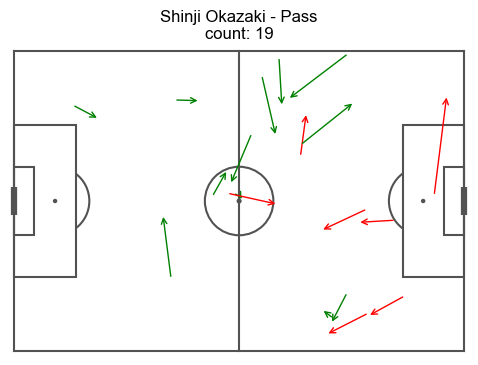

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

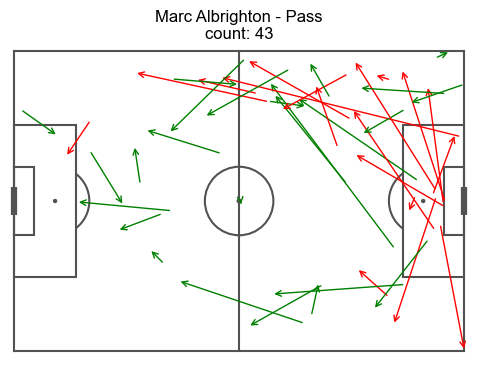

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

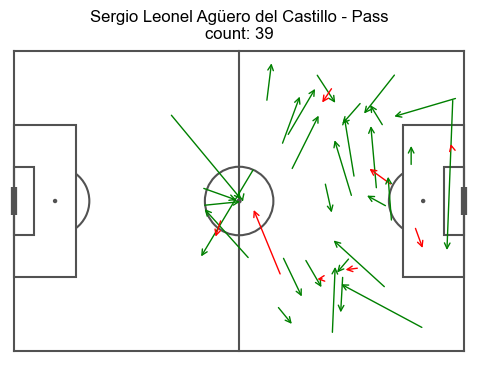

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

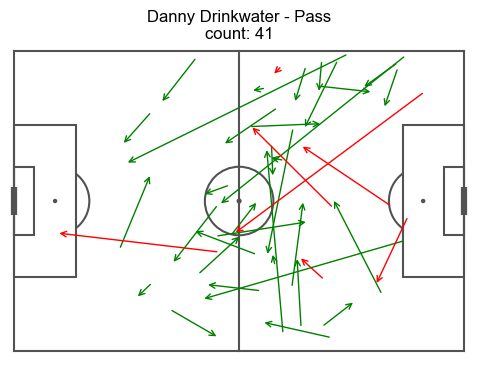

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

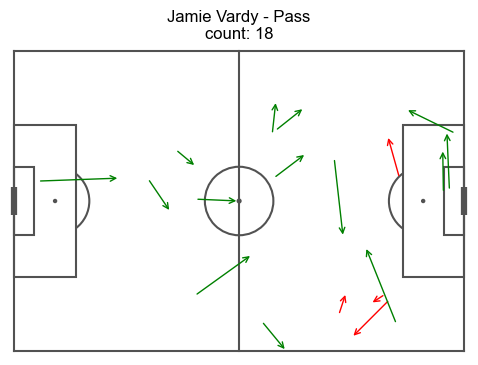

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

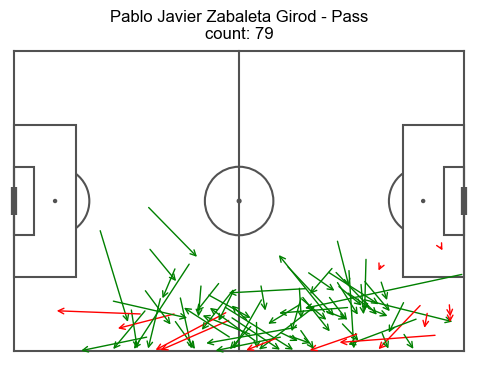

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

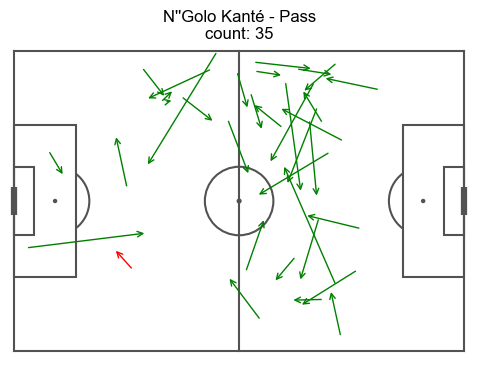

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

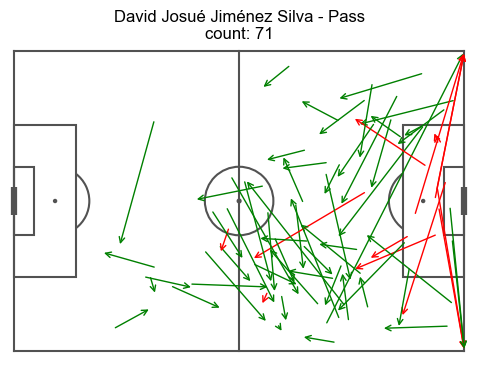

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

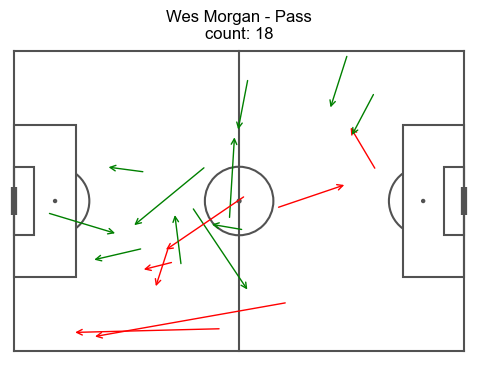

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

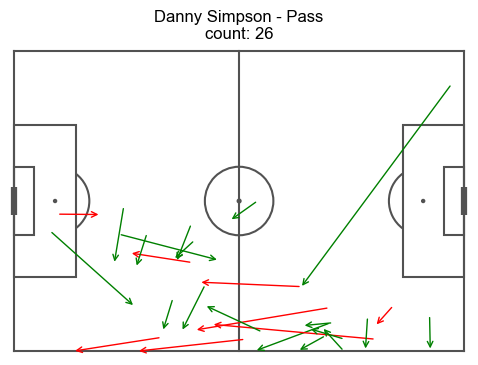

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

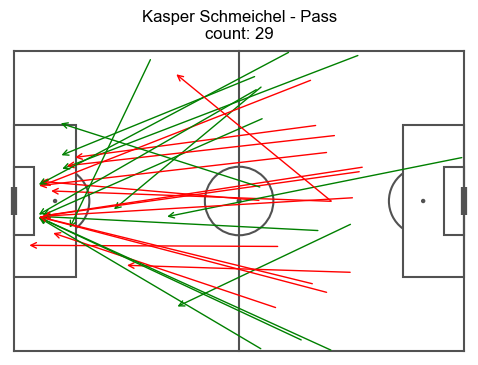

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

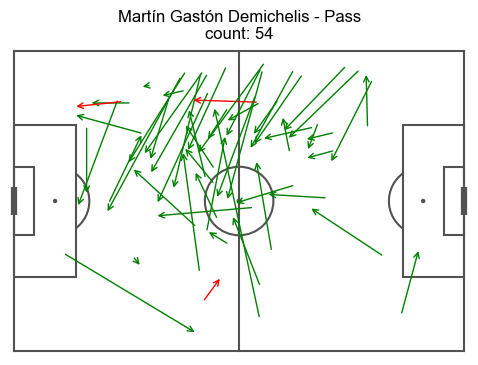

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

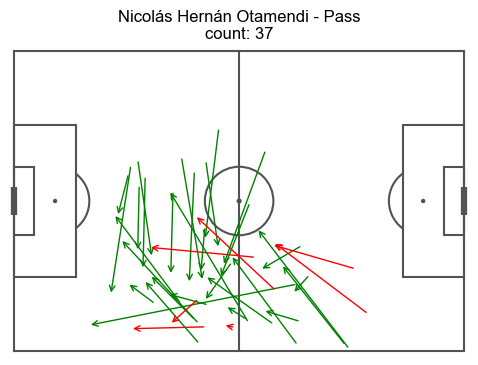

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

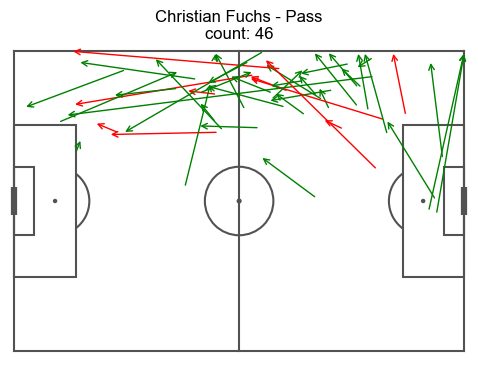

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

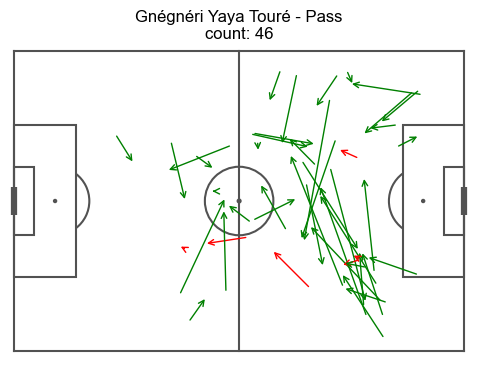

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

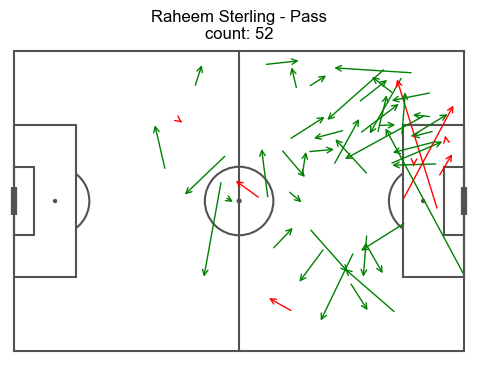

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

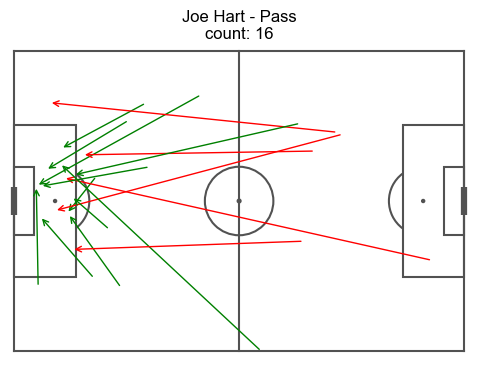

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

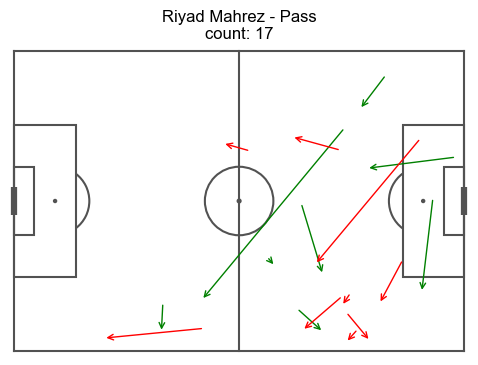

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

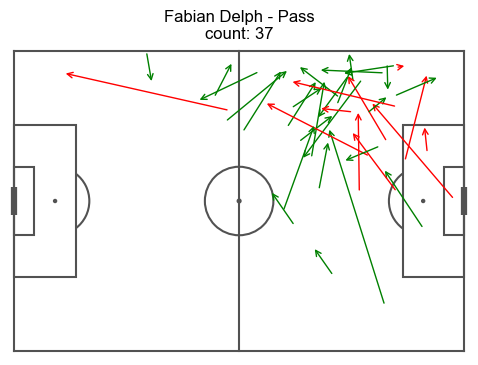

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

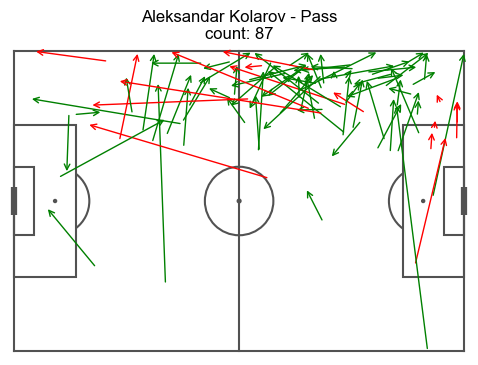

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

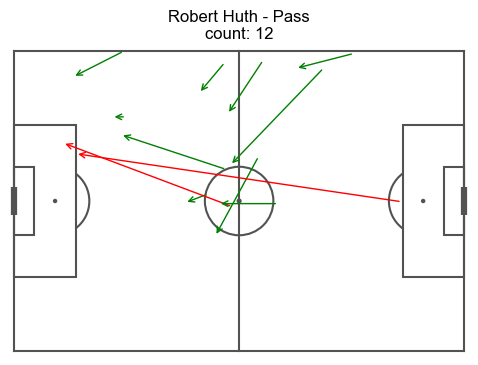

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

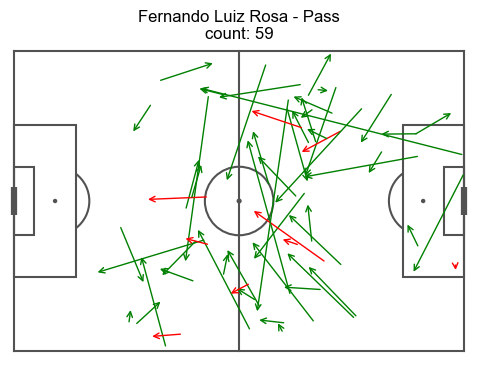

C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events[['x','y']] = pd.DataFrame(events.location.tolist(), index=events.index)
C:\Users\georg\AppData\Local\Temp\ipykernel_17988\1504552507.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [ ]:
for player in final.player_name.unique().tolist():
    
    if str(player) != "nan":

        plot_events(final, "Pass", player)